HW4_Q7_Time Series Classification Part 1: Feature Creation/Extraction - Hardik Prajapati(2678294168)

In [27]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
from sklearn.utils import resample
import warnings

In [32]:
warnings.filterwarnings('ignore')

data_file = "../data/AReM"

dirToRead = ["bending1", "bending2", "cycling", "lying", "sitting", "standing", "walking"]
columns_main = ['# Columns: time', 'avg_rss12', 'var_rss12', 'avg_rss13', 'var_rss13', 'avg_rss23', 'var_rss23']

Q7_b: test train split

In [8]:
def traintest_split(root):
    training_files = []
    testing_files = []
    for root, _, file in os.walk(root):
        for f in file:
            if (os.path.splitext(f)[1] == ".csv"):
                idx_csv = int(re.findall("\d+", f)[0])
                file_name = os.path.join(root, f)
                file_split = os.path.split(root)[-1]
                if (idx_csv <= 2 or (file_split not in ["bending1", "bending2"] and idx_csv == 3)):
                    testing_files.append(file_name)
                else:
                    training_files.append(file_name)
    return training_files, testing_files

train_data, test_data = traintest_split(data_file)


Q1_c: Feature Extraction

In [15]:
def read_data(files, feature, col, segs=1, standard=False):
    import csv
    sniffer = csv.Sniffer()
    
    feature_order = ['mean', 'std', 'min', '1stqtl', 'median', '3rdqtl','max']
    feature_idx = [feature + str(i) for i in range(1, 6 * segs + 1) for feature in feature_order]
    
    sample  = []
    labels = []
    for fil in files:
        parent_folder = os.path.dirname(fil)
        file_split = os.path.split(parent_folder)[-1]
        labels.append(file_split)
        
        separator = sniffer.sniff(open(fil).read()).delimiter
        if separator == ",":
            instance = pd.read_csv(fil, skiprows=5, header=None, 
                                       error_bad_lines=False, warn_bad_lines=False)
        else:
            instance = pd.read_csv(fil, skiprows=5, header=None, sep="\s+", 
                                       error_bad_lines=False, warn_bad_lines=False)
        
        instance.columns = col
        seg_len = int(instance.shape[0] / segs)
        segs_describe = []
        for i in range(segs):
            seg = instance[i * seg_len : min((i + 1) * seg_len, instance.shape[0])]
            describe = seg.describe().drop('count').drop(columns="# Columns: time").T
            segs_describe.append(describe.values.flatten())
        sample.append(np.concatenate(segs_describe, axis=None))
    
    feature_df = pd.DataFrame(sample, columns=feature_idx)
    feature_df = feature_df.loc[:, feature]
    
    if standard:
        feature_df = feature_df.apply(lambda col: (col-col.mean()) / (np.std(col) + 1e-9), axis = 0)
    

    feature_df['label'] = pd.Series(labels)
    
    return feature_df

statistics = ['min','max','mean','median','std','1stqtl', '3rdqtl']
feature = [stat + str(i) for i in range(1, 7) for stat in statistics]


train_df = read_data(train_data, feature, columns_main)
test_df = read_data(test_data, feature, columns_main)

In [16]:
train_df

,min1,max1,mean1,median1,std1,1stqtl1,3rdqtl1,min2,max2,mean2,...,1stqtl5,3rdqtl5,min6,max6,mean6,median6,std6,1stqtl6,3rdqtl6,label
0,35.00,47.40,43.954500,44.330,1.558835,43.00,45.0000,0.0,1.70,0.426250,...,35.3625,36.50,0.0,1.79,0.493292,0.430,0.513506,0.00,0.9400,bending1
1,33.00,47.75,42.179812,43.500,3.670666,39.15,45.0000,0.0,3.00,0.696042,...,30.4575,36.33,0.0,2.18,0.613521,0.500,0.524317,0.00,1.0000,bending1
2,33.00,45.75,41.678063,41.750,2.243490,41.33,42.7500,0.0,2.83,0.535979,...,28.4575,31.25,0.0,1.79,0.383292,0.430,0.389164,0.00,0.5000,bending1
3,37.00,48.00,43.454958,43.250,1.386098,42.50,45.0000,0.0,1.58,0.378083,...,22.2500,24.00,0.0,5.26,0.679646,0.500,0.622534,0.43,0.8700,bending1
4,36.25,48.00,43.969125,44.500,1.618364,43.31,44.6700,0.0,1.50,0.413125,...,20.5000,23.75,0.0,2.96,0.555312,0.490,0.487826,0.00,0.8300,bending1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64,20.75,46.25,34.763333,35.290,4.742208,31.67,38.2500,0.0,12.68,4.223792,...,14.2500,18.33,0.0,9.39,3.288271,3.270,1.647528,2.05,4.3050,walking
65,21.50,51.00,34.935812,35.500,4.645944,32.00,38.0625,0.0,12.21,4.115750,...,14.2375,18.25,0.0,10.21,3.280021,3.015,1.700918,2.12,4.5000,walking
66,18.33,47.67,34.333042,34.750,4.948770,31.25,38.0000,0.0,12.48,4.396958,...,13.7500,18.00,0.0,8.01,3.261583,2.980,1.617290,2.05,4.3200,walking
67,18.33,45.75,34.599875,35.125,4.731790,31.50,38.0000,0.0,15.37,4.398833,...,14.0000,18.25,0.0,8.86,3.289542,3.015,1.680170,2.12,4.2600,walking


In [18]:
test_df

,min1,max1,mean1,median1,std1,1stqtl1,3rdqtl1,min2,max2,mean2,...,1stqtl5,3rdqtl5,min6,max6,mean6,median6,std6,1stqtl6,3rdqtl6,label
0,37.25,45.00,40.624792,40.500,1.476967,39.2500,42.0000,0.0,1.30,0.358604,...,33.0000,36.0000,0.0,1.92,0.570583,0.430,0.582915,0.0000,1.300,bending1
1,38.00,45.67,42.812812,42.500,1.435550,42.0000,43.6700,0.0,1.22,0.372437,...,32.0000,34.5000,0.0,3.11,0.571083,0.430,0.601010,0.0000,1.300,bending1
2,12.75,51.00,24.562958,24.250,3.737514,23.1875,26.5000,0.0,6.87,0.590833,...,20.5000,27.0000,0.0,4.97,0.700188,0.500,0.693720,0.4300,0.870,bending2
3,0.00,42.75,27.464604,28.000,3.583582,25.5000,30.0000,0.0,7.76,0.449708,...,15.0000,20.7500,0.0,6.76,1.122125,0.830,1.012342,0.4700,1.300,bending2
4,24.25,45.00,37.177042,36.250,3.581301,34.5000,40.2500,0.0,8.58,2.374208,...,17.9500,21.7500,0.0,9.34,2.921729,2.500,1.852600,1.5000,3.900,cycling
5,28.75,44.75,37.561187,36.875,3.226507,35.2500,40.2500,0.0,9.91,2.080687,...,18.0000,21.5000,0.0,9.62,2.765896,2.450,1.769203,1.4100,3.770,cycling
6,22.00,44.67,37.058708,36.000,3.710180,34.5000,40.0625,0.0,14.17,2.438146,...,16.0000,21.0000,0.0,8.55,2.983750,2.570,1.815730,1.5000,4.150,cycling
7,23.50,30.00,27.716375,27.500,1.442253,27.0000,29.0000,0.0,1.79,0.363687,...,5.5000,10.7500,0.0,4.50,0.734271,0.710,0.613688,0.4300,1.000,lying
8,24.75,48.33,44.182937,48.000,7.495615,48.0000,48.0000,0.0,3.11,0.101875,...,2.0000,5.5425,0.0,3.91,0.692771,0.500,0.675781,0.3225,0.940,lying
9,48.00,48.25,48.004167,48.000,0.032038,48.0000,48.0000,0.0,0.43,0.007167,...,4.6700,10.0000,0.0,2.50,0.641229,0.500,0.388372,0.4600,0.830,lying


Q7_c_ii: Research what types of time-domain features are usually used in time series
classification and list them (examples are minimum, maximum, mean, etc).

Time-domain features used in time-series classification.
Statistical Features:
1. Mean: It is the best measure of central tendency when the data distribution is continuous.
2. Median: It is a good feature of central tendency that is less affected by outliers and skewed data.
3. Standard Deviation: It is an ideal measure of dispersion.
4. Skewness
5. Minimum and Maximum : They are the extreme values of the range

Q7_c_iii: Estimate the standard deviation of each of the time-domain features you
extracted from the data. Then, use Python's bootstrapped or any other
method to build a 90% bootsrap confidence interval for the standard deviation
of each feature

In [20]:
train_df.describe().loc['std']

min1       8.794295
max1       4.429182
mean1      4.917692
median1    4.956111
std1       1.758670
1stqtl1    5.731647
3rdqtl1    4.783645
min2       0.000000
max2       5.147841
mean2      1.600701
median2    1.436960
std2       0.902808
1stqtl2    0.952201
3rdqtl2    2.158416
min3       3.053869
max3       4.759853
mean3      3.863097
median3    3.845730
std3       0.995959
1stqtl3    4.145255
3rdqtl3    3.946023
min4       0.000000
max4       2.302408
mean4      1.179861
median4    1.150092
std4       0.473576
1stqtl4    0.842501
3rdqtl4    1.566564
min5       5.368786
max5       5.449726
mean5      5.120426
median5    5.267414
std5       1.057998
1stqtl5    5.543882
3rdqtl5    4.957231
min6       0.051766
max6       2.540166
mean6      1.171401
median6    1.104626
std6       0.519420
1stqtl6    0.774358
3rdqtl6    1.550393
Name: std, dtype: float64

In [24]:
def boot_strap(data, num_resample, operation, low=5, upper=95):
    estimation = []
    for i in range(num_resample):
        resampled_data = resample(data, replace=True, n_samples=data.shape[0])
        estimation.append(resampled_data.apply(lambda col : operation(col, ddof=1), axis=0))
    estimation = pd.DataFrame(estimation, columns=list(data.columns))
    conf_interval = estimation.apply(lambda col : (np.percentile(col, 5), np.percentile(col, 95)), axis=0)
    return conf_interval.apply(np.around, args=(2,))

our_interval=boot_strap(train_df.iloc[:,:-1],1000,np.std)
our_interval

,min1,max1,mean1,median1,std1,1stqtl1,3rdqtl1,min2,max2,mean2,...,std5,1stqtl5,3rdqtl5,min6,max6,mean6,median6,std6,1stqtl6,3rdqtl6
0,7.54,3.37,4.34,4.33,1.55,5.15,3.98,0.0,4.63,1.40,...,0.78,4.06,3.61,0.00,2.24,1.07,1.00,0.48,0.70,1.41
1,10.02,5.44,5.44,5.51,1.94,6.24,5.52,0.0,5.51,1.73,...,1.28,6.78,6.07,0.09,2.82,1.23,1.17,0.55,0.83,1.63


Q7_c_iv: Use your judgement to select the three most important time-domain features
(one option may be min, mean, and max)

In [26]:
bending_train_df = pd.DataFrame(train_df)
bending_train_df.loc[bending_train_df['label'].isin(['bending1', 'bending2']), 'label'] = 1
bending_train_df.loc[bending_train_df['label'] != 1, 'label'] = 0
bending_train_df

,min1,max1,mean1,median1,std1,1stqtl1,3rdqtl1,min2,max2,mean2,...,1stqtl5,3rdqtl5,min6,max6,mean6,median6,std6,1stqtl6,3rdqtl6,label
0,35.00,47.40,43.954500,44.330,1.558835,43.00,45.0000,0.0,1.70,0.426250,...,35.3625,36.50,0.0,1.79,0.493292,0.430,0.513506,0.00,0.9400,1
1,33.00,47.75,42.179812,43.500,3.670666,39.15,45.0000,0.0,3.00,0.696042,...,30.4575,36.33,0.0,2.18,0.613521,0.500,0.524317,0.00,1.0000,1
2,33.00,45.75,41.678063,41.750,2.243490,41.33,42.7500,0.0,2.83,0.535979,...,28.4575,31.25,0.0,1.79,0.383292,0.430,0.389164,0.00,0.5000,1
3,37.00,48.00,43.454958,43.250,1.386098,42.50,45.0000,0.0,1.58,0.378083,...,22.2500,24.00,0.0,5.26,0.679646,0.500,0.622534,0.43,0.8700,1
4,36.25,48.00,43.969125,44.500,1.618364,43.31,44.6700,0.0,1.50,0.413125,...,20.5000,23.75,0.0,2.96,0.555312,0.490,0.487826,0.00,0.8300,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64,20.75,46.25,34.763333,35.290,4.742208,31.67,38.2500,0.0,12.68,4.223792,...,14.2500,18.33,0.0,9.39,3.288271,3.270,1.647528,2.05,4.3050,0
65,21.50,51.00,34.935812,35.500,4.645944,32.00,38.0625,0.0,12.21,4.115750,...,14.2375,18.25,0.0,10.21,3.280021,3.015,1.700918,2.12,4.5000,0
66,18.33,47.67,34.333042,34.750,4.948770,31.25,38.0000,0.0,12.48,4.396958,...,13.7500,18.00,0.0,8.01,3.261583,2.980,1.617290,2.05,4.3200,0
67,18.33,45.75,34.599875,35.125,4.731790,31.50,38.0000,0.0,15.37,4.398833,...,14.0000,18.25,0.0,8.86,3.289542,3.015,1.680170,2.12,4.2600,0


Based on the principle to have relatively clearly seperated distributions, I choose max, mean and 3rd_Quartile as the top 3

Q7_c_v: Assume that you want to use the training set to classify bending from other
activities, i.e. you have a binary classification problem. Depict scatter plots
of the features you specified in 7(c)iv extracted from time series 1, 2, and 6 of
each instance, and use color to distinguish bending vs. other activities.

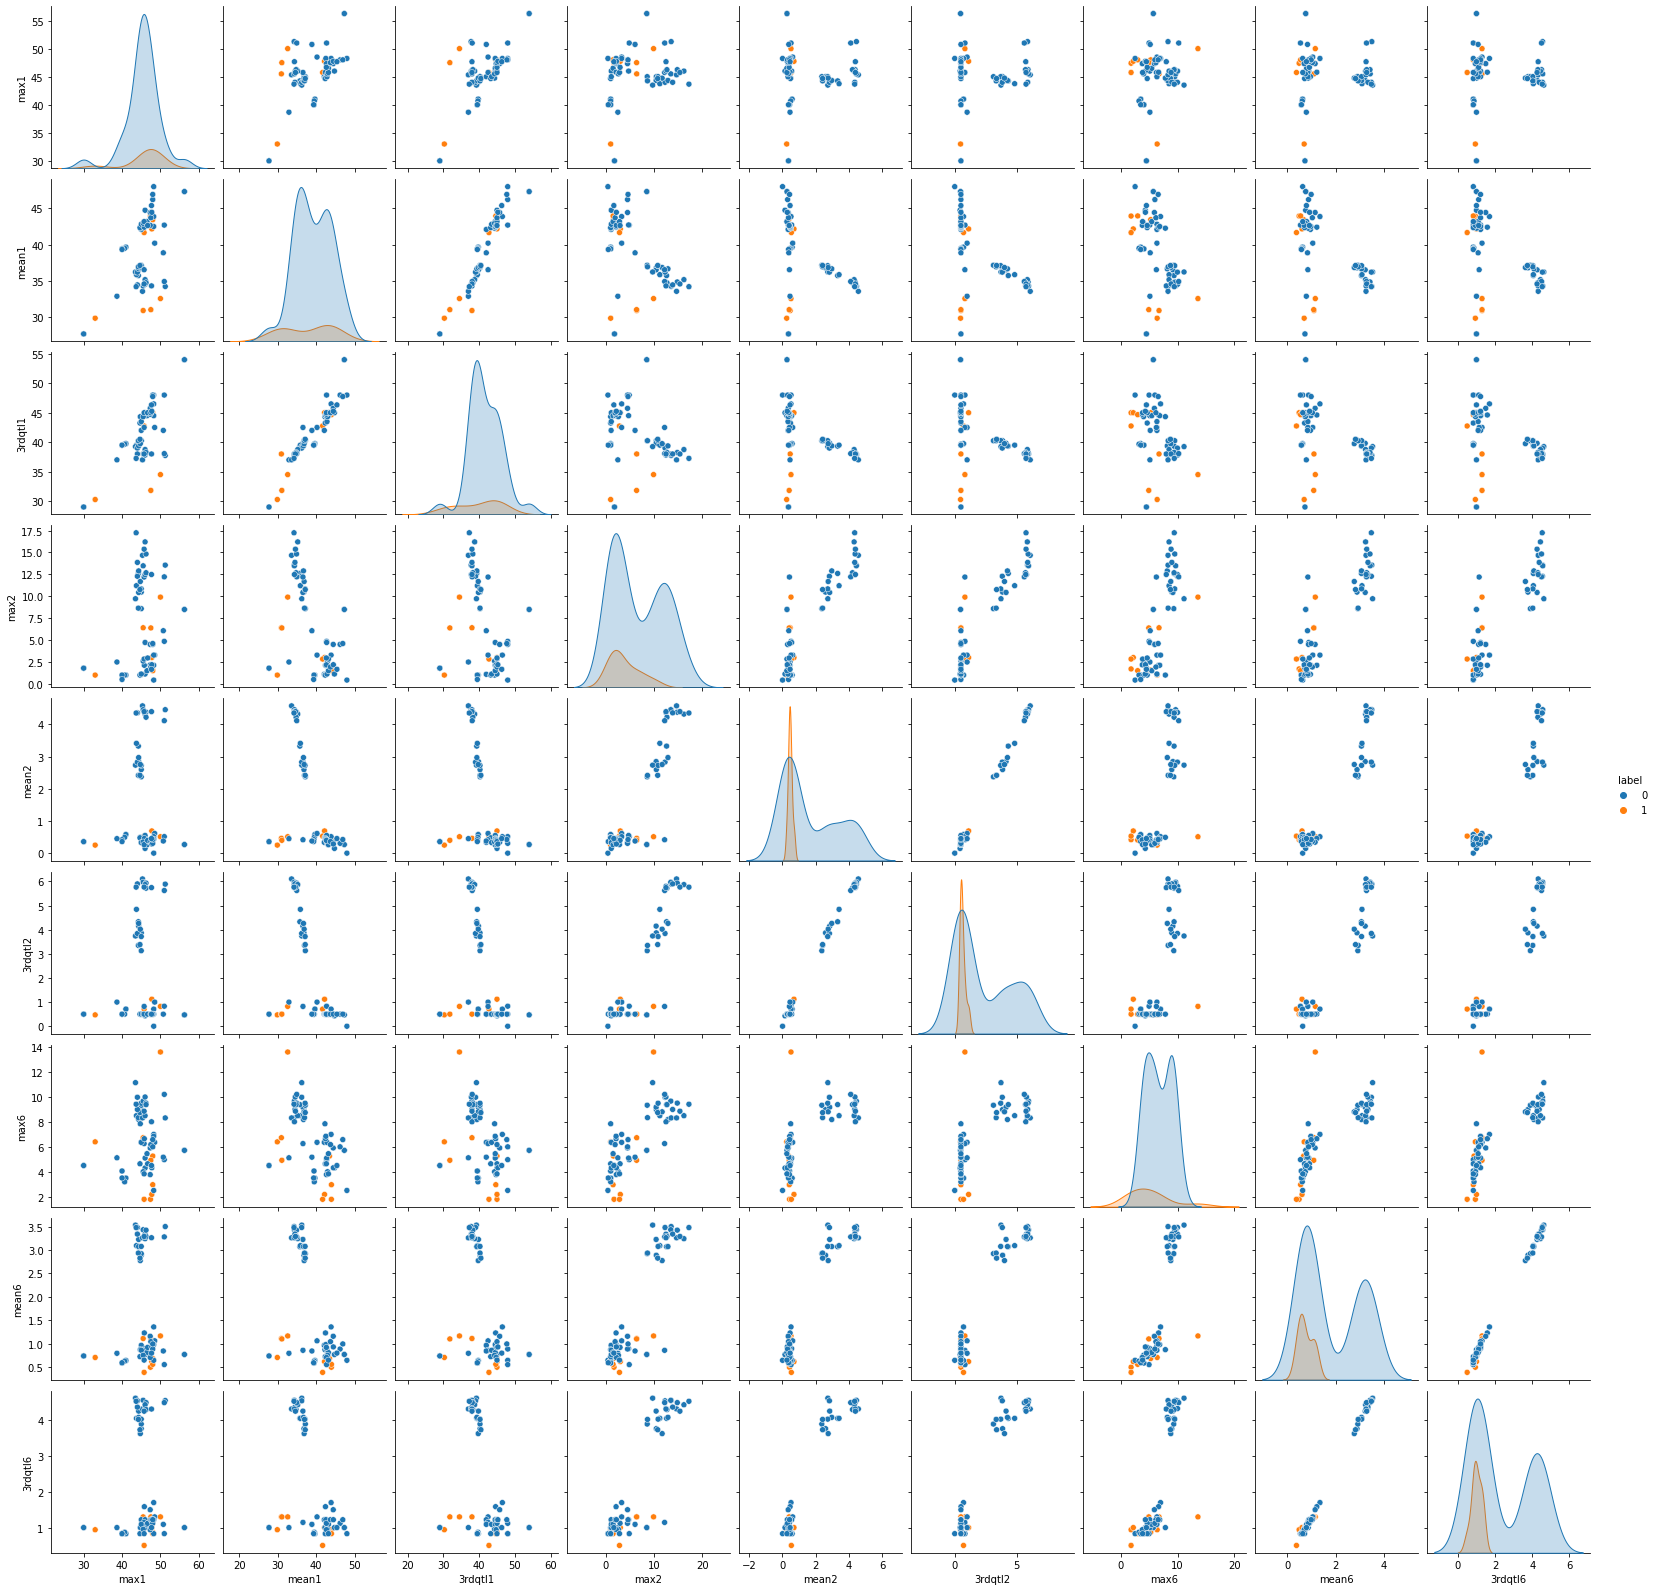

In [35]:
def join_plot(feature, data, nums):
    feature_selection = [f + str(i) for i in nums for f in feature]
    feature_data = data[feature_selection + ['label']]
    sns.pairplot(feature_data, hue='label')
    plt.show()

join_plot( ['max', 'mean', '3rdqtl'],bending_train_df, [1, 2, 6])